In [1]:
import numpy as np
from typing import List, Tuple, Optional
import json
import matplotlib.pyplot as plt

class Layer:
    def __init__(self, input_size: int, output_size: int, activation: str = 'relu'):
        """Initialize a neural network layer with weights and biases"""
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
        self.activation = activation

        # Cache for backpropagation
        self.input = None
        self.output = None
        self.activation_output = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass through the layer"""
        self.input = X
        self.output = np.dot(X, self.weights) + self.biases
        self.activation_output = self._activate(self.output)
        return self.activation_output

    def _activate(self, x: np.ndarray) -> np.ndarray:
        """Apply activation function"""
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        raise ValueError(f"Unsupported activation function: {self.activation}")

    def _activate_derivative(self, x: np.ndarray) -> np.ndarray:
        """Compute derivative of activation function"""
        if self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation == 'sigmoid':
            s = 1 / (1 + np.exp(-x))
            return s * (1 - s)
        elif self.activation == 'tanh':
            return 1 - np.tanh(x)**2
        raise ValueError(f"Unsupported activation function: {self.activation}")


Epoch 0: Loss = 0.9826, Accuracy = 0.2200
Epoch 100: Loss = 0.7026, Accuracy = 0.2200
Epoch 200: Loss = 0.6688, Accuracy = 0.2200
Epoch 300: Loss = 0.6612, Accuracy = 0.2200
Epoch 400: Loss = 0.6589, Accuracy = 0.2200
Epoch 500: Loss = 0.6581, Accuracy = 0.2200
Epoch 600: Loss = 0.6662, Accuracy = 0.4700


<ipython-input-1-d4bea9b9028f>:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 700: Loss = nan, Accuracy = 0.5400
Epoch 800: Loss = nan, Accuracy = 0.5400
Epoch 900: Loss = nan, Accuracy = 0.5400


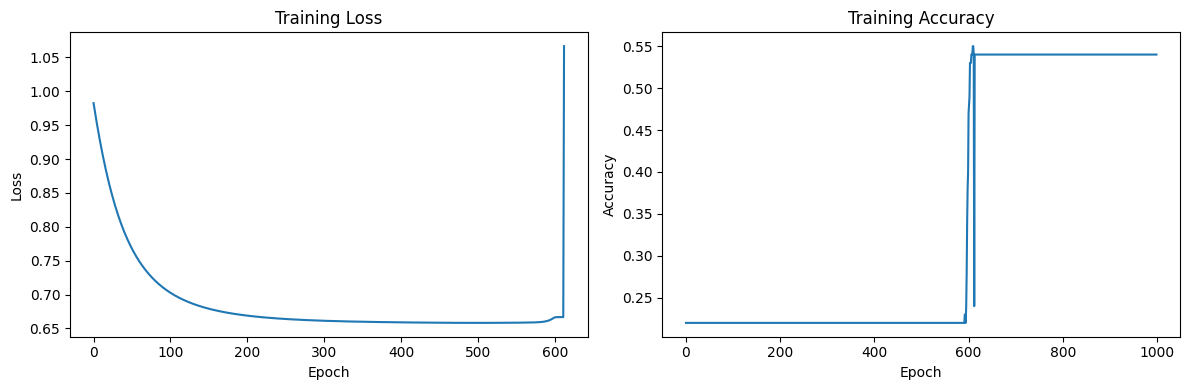

In [2]:
class NeuralNetwork:
    def __init__(self, layer_sizes: List[int], activations: List[str]):
        """Initialize neural network with specified layer sizes and activations"""
        if len(layer_sizes) < 2:
            raise ValueError("Need at least input and output layers")
        if len(layer_sizes) - 1 != len(activations):
            raise ValueError("Number of activations must match number of layers - 1")

        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i + 1], activations[i]))

        self.loss_history = []
        self.accuracy_history = []

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass through entire network"""
        current_output = X
        for layer in self.layers:
            current_output = layer.forward(current_output)
        return current_output

    def backward(self, X: np.ndarray, y: np.ndarray, learning_rate: float = 0.01):
        """Backward pass for parameter updates"""
        m = X.shape[0]

        # Compute initial gradient
        output = self.layers[-1].activation_output
        delta = output - y

        # Backpropagate through layers
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]

            # Compute gradients
            if i != len(self.layers) - 1:  # Hidden layers
                delta = np.dot(delta, self.layers[i + 1].weights.T) * layer._activate_derivative(layer.output)

            # Update parameters
            layer.weights -= learning_rate * np.dot(layer.input.T, delta) / m
            layer.biases -= learning_rate * np.sum(delta, axis=0, keepdims=True) / m

    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000, learning_rate: float = 0.01,
             batch_size: Optional[int] = None, verbose: bool = True) -> None:
        """Train the neural network"""
        m = X.shape[0]
        batch_size = batch_size if batch_size else m

        for epoch in range(epochs):
            # Mini-batch training
            for i in range(0, m, batch_size):
                batch_X = X[i:i + batch_size]
                batch_y = y[i:i + batch_size]

                # Forward and backward passes
                self.forward(batch_X)
                self.backward(batch_X, batch_y, learning_rate)

            # Track metrics
            predictions = self.predict(X)
            loss = self.compute_loss(predictions, y)
            accuracy = self.compute_accuracy(predictions, y)

            self.loss_history.append(loss)
            self.accuracy_history.append(accuracy)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        return self.forward(X)

    def compute_loss(self, predictions: np.ndarray, y: np.ndarray) -> float:
        """Compute MSE loss"""
        return np.mean(np.square(predictions - y))

    def compute_accuracy(self, predictions: np.ndarray, y: np.ndarray) -> float:
        """Compute classification accuracy"""
        return np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))

    def plot_training_history(self) -> None:
        """Plot training metrics history"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath: str) -> None:
        """Save model parameters to file"""
        model_params = {
            'architecture': [layer.weights.shape[0] for layer in self.layers] +
                          [self.layers[-1].weights.shape[1]],
            'activations': [layer.activation for layer in self.layers],
            'weights': [layer.weights.tolist() for layer in self.layers],
            'biases': [layer.biases.tolist() for layer in self.layers]
        }
        with open(filepath, 'w') as f:
            json.dump(model_params, f)

    @classmethod
    def load_model(cls, filepath: str) -> 'NeuralNetwork':
        """Load model from file"""
        with open(filepath, 'r') as f:
            model_params = json.load(f)

        network = cls(model_params['architecture'], model_params['activations'])
        for i, layer in enumerate(network.layers):
            layer.weights = np.array(model_params['weights'][i])
            layer.biases = np.array(model_params['biases'][i])

        return network

Epoch 0: Loss = 0.9573, Accuracy = 0.1900
Epoch 100: Loss = 0.7214, Accuracy = 0.1900
Epoch 200: Loss = 0.6876, Accuracy = 0.1900
Epoch 300: Loss = 0.6767, Accuracy = 0.1900
Epoch 400: Loss = 0.6717, Accuracy = 0.1900
Epoch 500: Loss = 0.6743, Accuracy = 0.3800
Epoch 600: Loss = nan, Accuracy = 0.5400
Epoch 700: Loss = nan, Accuracy = 0.5400


<ipython-input-1-d4bea9b9028f>:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 800: Loss = nan, Accuracy = 0.5400
Epoch 900: Loss = nan, Accuracy = 0.5400


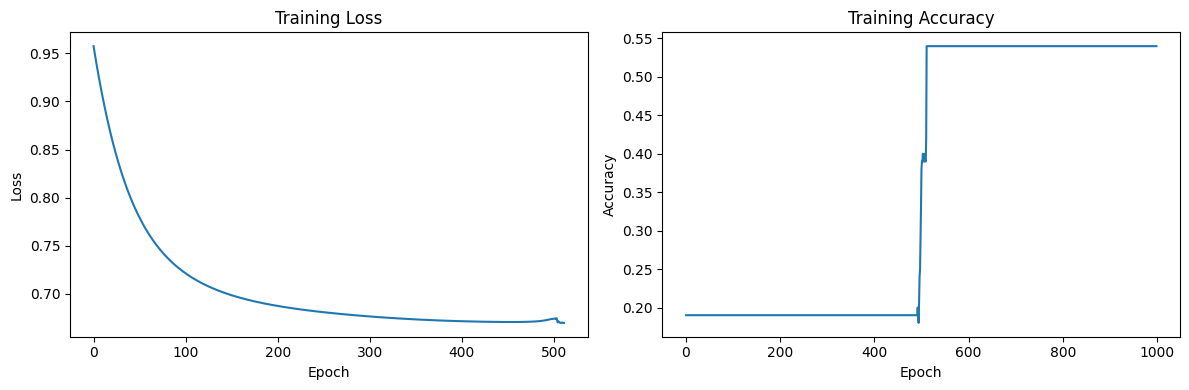

In [5]:
# Create a network with 2 hidden layers: input(4) -> hidden1(6) -> hidden2(4) -> output(3)
layer_sizes = [4, 6, 4, 3]
activations = ['relu', 'relu', 'sigmoid']  # One activation for each layer except input
nn = NeuralNetwork(layer_sizes, activations)

# Training
X_train = np.random.randn(100, 4)  # 100 samples, 4 features
y_train = np.random.randint(0, 3, size=(100, 3))  # One-hot encoded labels
nn.train(X_train, y_train, epochs=1000, learning_rate=0.01, batch_size=32)

# Visualize training progress
nn.plot_training_history()

# Make predictions
predictions = nn.predict(X_train)

# Save and load the model
nn.save_model('my_model.json')
loaded_nn = NeuralNetwork.load_model('my_model.json')

Welcome to the Neural Network Builder!

=== Neural Network Configuration ===
Enter total number of layers (including input and output): 4
Enter number of features (input layer size): 4
Enter number of neurons for hidden layer 1: 6
Enter number of neurons for hidden layer 2: 4
Enter number of classes (output layer size): 3

Available activation functions: relu, sigmoid, tanh
Enter activation function for layer 1: relu
Enter activation function for layer 2: relu
Enter activation function for layer 3: sigmoid

=== Training Configuration ===
Enter number of epochs: 1000
Enter learning rate (e.g., 0.01): 0.01
Enter batch size: 32

Generating sample training data...

Training the neural network...
Epoch 0: Loss = 0.2494, Accuracy = 0.4200
Epoch 100: Loss = 0.2262, Accuracy = 0.4200
Epoch 200: Loss = 0.2235, Accuracy = 0.4200
Epoch 300: Loss = 0.2234, Accuracy = 0.4200
Epoch 400: Loss = 0.2235, Accuracy = 0.4200
Epoch 500: Loss = 0.2235, Accuracy = 0.4200
Epoch 600: Loss = 0.2236, Accuracy = 

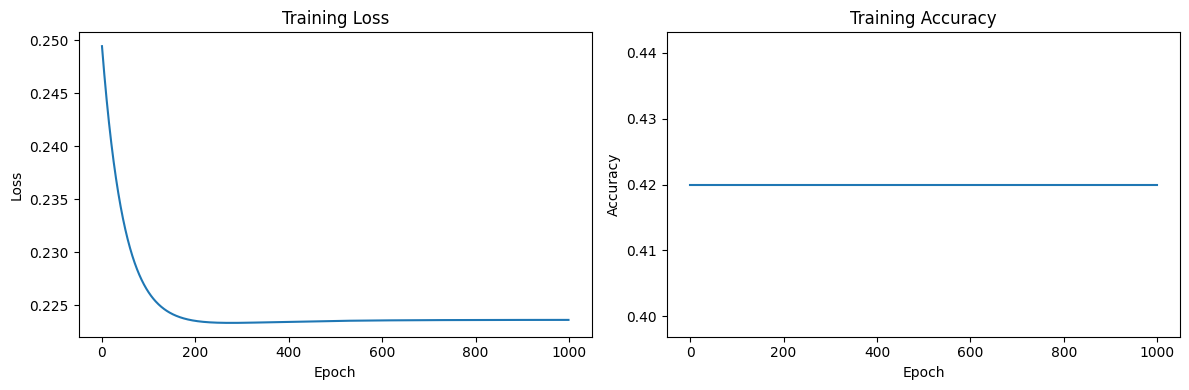


Final training accuracy: 0.4200

Would you like to save the model? (yes/no): no


In [6]:
import numpy as np
from typing import List, Tuple, Optional
import json
import matplotlib.pyplot as plt

# [Previous Layer and NeuralNetwork class implementations remain the same...]
# [Include all the previous code here, then add the following main interaction code]

def get_user_input():
    """Get neural network configuration from user"""
    print("\n=== Neural Network Configuration ===")

    # Get number of layers
    n_layers = int(input("Enter total number of layers (including input and output): "))

    # Get layer sizes
    layer_sizes = []
    for i in range(n_layers):
        if i == 0:
            size = int(input(f"Enter number of features (input layer size): "))
        elif i == n_layers - 1:
            size = int(input(f"Enter number of classes (output layer size): "))
        else:
            size = int(input(f"Enter number of neurons for hidden layer {i}: "))
        layer_sizes.append(size)

    # Get activation functions
    print("\nAvailable activation functions: relu, sigmoid, tanh")
    activations = []
    for i in range(n_layers - 1):  # One less than total layers
        while True:
            activation = input(f"Enter activation function for layer {i+1}: ").lower()
            if activation in ['relu', 'sigmoid', 'tanh']:
                activations.append(activation)
                break
            print("Invalid activation function! Please choose from: relu, sigmoid, tanh")

    # Get training parameters
    print("\n=== Training Configuration ===")
    epochs = int(input("Enter number of epochs: "))
    learning_rate = float(input("Enter learning rate (e.g., 0.01): "))
    batch_size = int(input("Enter batch size: "))

    return layer_sizes, activations, epochs, learning_rate, batch_size

def generate_sample_data(input_size: int, output_size: int, n_samples: int = 100):
    """Generate sample data for testing"""
    X = np.random.randn(n_samples, input_size)
    y = np.zeros((n_samples, output_size))
    # Create one-hot encoded labels
    for i in range(n_samples):
        y[i, np.random.randint(0, output_size)] = 1
    return X, y

def main():
    """Main function to run the neural network"""
    print("Welcome to the Neural Network Builder!")

    # Get configuration from user
    layer_sizes, activations, epochs, learning_rate, batch_size = get_user_input()

    # Create the neural network
    nn = NeuralNetwork(layer_sizes, activations)

    # Generate sample data
    print("\nGenerating sample training data...")
    X_train, y_train = generate_sample_data(layer_sizes[0], layer_sizes[-1])

    # Train the network
    print("\nTraining the neural network...")
    nn.train(X_train, y_train, epochs=epochs, learning_rate=learning_rate,
            batch_size=batch_size, verbose=True)

    # Plot training history
    print("\nPlotting training history...")
    nn.plot_training_history()

    # Make predictions
    predictions = nn.predict(X_train)
    final_accuracy = nn.compute_accuracy(predictions, y_train)
    print(f"\nFinal training accuracy: {final_accuracy:.4f}")

    # Save model
    save = input("\nWould you like to save the model? (yes/no): ").lower()
    if save == 'yes':
        filename = input("Enter filename to save model (e.g., 'my_model.json'): ")
        nn.save_model(filename)
        print(f"Model saved as {filename}")

if __name__ == "__main__":
    main()